In [1]:
import os, h5py
import pandas as pd
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
from datetime import datetime
import glob
import pyproj
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [75]:
### Extract parameters from the ATL08 product first. This contains several flags
### such as night flag, cloud flag, canopy uncertainty, watermask etc.

## Create a dataframe for collecting all data
df = pd.DataFrame([], columns=["date", "lats", "lons", "seg_id_begin", "seg_id_end", "night_flag", 
                              "canopy_openness", "canopy_flag", "h_canopy_uncertainty", "cloud_flag_atm", 
                              "water_mask", "landcover", "beam_num"])

### Extract data for each hdf5 file in the folder from Oct 2018 to Feb 2021

os.chdir('/home/shashank/Downloads/icesat2/icesat2_data/ATL08/')

for filename in sorted(glob.glob("*.h5")):    
    
     #### Extract date from file name    
     date_str = filename.split("_")[1][0:8]
     date_obj  = datetime.strptime(date_str,'%Y%m%d')
     date = datetime.strftime(date_obj, '%d %B,%Y')
     
     ### Import the hdf file 
     f = h5py.File(filename, 'r')

     ### Extract data for all 3 strong beams
     beam_numbers = ['/gt1r', '/gt2r', '/gt3r']

     for beam in beam_numbers: 
         ### Extract required parameters from hdf
         ### Each of these parameters are calculated for a 100m segment
         lons = pd.DataFrame(f[beam + '/land_segments/longitude'][:])
         lats = pd.DataFrame(f[beam + '/land_segments/latitude'][:])
         segment_id_begin = pd.DataFrame(f[beam + '/land_segments/segment_id_beg'][:])
         segment_id_end = pd.DataFrame(f[beam + '/land_segments/segment_id_end'][:])
         night_flag = pd.DataFrame(f[beam + '/land_segments/night_flag'][:]) ## day=0, night=1 
         can_open = pd.DataFrame(f[beam + '/land_segments/canopy/canopy_openness'][:]) ### ** ###
         h_can_uncertainty = pd.DataFrame(f[beam + '/land_segments/canopy/h_canopy_uncertainty'][:])
         cloud_flag_atm = pd.DataFrame(f[beam + '/land_segments/cloud_flag_atm'][:]) ## Flag > 0: Clouds/aerosols could be present
         seg_watermask = pd.DataFrame(f[beam + '/land_segments/segment_watermask'][:]) ## 0:no water 1:water
         seg_landcover = pd.DataFrame(f[beam + '/land_segments/segment_landcover'][:]) ## MODIS landcover 17 classes http://www.worldhairsalon.com/sage/data-and-models/friedl_rse2010.pdf   
   
         ## Add a column with strong beam number
         beam_num = []
         for i in range(0, len(lons)):
            beam_num.append(beam)
         beam_num = pd.DataFrame(beam_num, columns=[""])
    
         ## Create a variable which counts the number of times '1' appears in the canopy flag
         ## -1: no data within geosegment available for analysis; 0: indicates no canopy photons within geosegment; 1: indicates canopy photons within geosegment
         ## For example, a 100 m ATL08 segment might have the following subset_can_flags: {-1 -1 -1 1 1} which would translate that no photons (canopy or ground) were available for processing in the first three geosegments.
         canopy_flag = pd.DataFrame(f[beam + '/land_segments/canopy/subset_can_flag'][:])
         counter = pd.DataFrame([], index=np.arange(0, len(canopy_flag)), columns=["counter"])
         for i in range(0, len(counter)):
            count=0
            segment = canopy_flag.iloc[i,:]
            for j in range(0, 5):
                if segment[j] == 1:
                  count+=1
            counter["counter"][i] = count         
            
         ### Create a column of dates 
         dates_arr = []
         for i in range(0, len(lats)):
            dates_arr.append(date)
            dates_df = pd.DataFrame(dates_arr, columns=["date"])
         
         ### Combine all the extracted parameters into a dataframe
         canopy_height_data = pd.concat([dates_df, lats, lons, segment_id_begin, segment_id_end, night_flag, 
                                       can_open, counter, h_can_uncertainty, cloud_flag_atm, 
                                        seg_watermask, seg_landcover, beam_num], axis=1, ignore_index=True)
         canopy_height_data.columns = df.columns
            
         ### Drop pixels with no-data value and canopy openness value equal to 3.4028235e+38
         ## Consider only pixels with h_canopy_uncertainty < 10
         canopy_height_data = canopy_height_data[canopy_height_data["canopy_openness"] < 1e+38]
         canopy_height_data = canopy_height_data[canopy_height_data["h_canopy_uncertainty"] < 5]
        
         ### Consider only pixels within the Cabo Rojo region
         canopy_height_data = canopy_height_data[(canopy_height_data["lats"]>18.03) & 
                                                 (canopy_height_data["lats"]<18.08)]
         canopy_height_data = canopy_height_data[(canopy_height_data["lons"] > -67.20) &
                                                 (canopy_height_data["lons"] < -66.78)]
            
         ### Extract places with no cloud/aerosol cover and no water
         canopy_height_data = canopy_height_data[canopy_height_data["cloud_flag_atm"] == 0]
         canopy_height_data = canopy_height_data[canopy_height_data["water_mask"] == 0]   
    
         ### Extract only day/night time data
         #canopy_height_data = canopy_height_data[canopy_height_data["night_flag"]==1]
        
         ## Remove unwanted landcover classes permanent wetlands(11), urban(13), barren(16), water(17)
         #canopy_height_data = canopy_height_data[(canopy_height_data["landcover"]!=13) &
         #                                        (canopy_height_data["landcover"]<=14) &
         #                                        (canopy_height_data["landcover"]!=11)]
        
         ### Extract data with data quality counter
         ## Most points have counter value 5. So, choosing only those. 
         canopy_height_data = canopy_height_data[canopy_height_data["canopy_flag"]==5]
            
         ### Append canopy height data at the bottom of df
         df = df.append(canopy_height_data, ignore_index=True)

df.to_csv("ATL08_shortlisted_segments.csv", sep=",", header=True, index=False)

In [31]:
os.chdir("/home/shashank/Downloads/icesat2/icesat2_data/ATL08")
atl08 = pd.read_csv("ATL08_shortlisted_segments.csv", header=0)

atl08_day = atl08[atl08["night_flag"] == 0].reset_index(drop=True)
atl08_night = atl08[atl08["night_flag"] == 1].reset_index(drop=True)

seg_data_source = atl08_day

## Create a list of 20-m segment ids 
seg_20m_list = []
for i in range(0, len(seg_data_source)):
    for j in range(int(seg_data_source["seg_id_begin"][i]), int(seg_data_source["seg_id_end"][i] + 1)):
        seg_20m_list.append(j)

## Then extract the ATL03 parameters. This code considers only one h5 file. Complete analysis on Theseus. 
## The Theseus code is present at the location /home/vk5/icesat_2

os.chdir('/home/shashank/Downloads/icesat2/icesat2_data/ATL03/sample_h5_cabo_rojo')
f = h5py.File('ATL03_20181028191317_04610101_004_01.h5', 'r')
atl03_photon_data = pd.DataFrame([], columns=["reference_ph_lat", "reference_ph_lon", "segment_id", 
                                              "index_within_seg"])

beam_numbers = ['/gt1r', '/gt2r', '/gt3r']

for beam in beam_numbers:
    #ph_lats = pd.DataFrame(f[beam + '/heights/lat_ph'][:])
    #ph_lons = pd.DataFrame(f[beam + '/heights/lon_ph'][:])
    #id_count = pd.DataFrame(f[beam + '/heights/ph_id_count'][:])
    #quality = pd.DataFrame(f[beam + '/heights/quality_ph'][:]) ## value >= 1 : possible afterpulse
    ref_ph_index_within_seg = pd.DataFrame(f[beam + '/geolocation/reference_photon_index'][:], columns=[""])
    ref_ph_lat = pd.DataFrame(f[beam + '/geolocation/reference_photon_lat'][:])
    ref_ph_lon = pd.DataFrame(f[beam + '/geolocation/reference_photon_lon'][:])
    seg_id = pd.DataFrame(f[beam + '/geolocation/segment_id'][:])
    
    ## Combine reference photon information
    ref_ph = pd.concat([ref_ph_lat, ref_ph_lon, seg_id, ref_ph_index_within_seg], axis=1)
    ref_ph.columns = atl03_photon_data.columns
    
    ## Extract only those 20-m segment ids which exist in atl08 shortlist 
    ref_ph = ref_ph[ref_ph["segment_id"].isin(seg_20m_list)].reset_index(drop=True)
    
    atl03_photon_data = atl03_photon_data.append(ref_ph, ignore_index=True)

In [10]:
### Extract canopy heights from ATL08 photon data. 
os.chdir('/home/shashank/Downloads/icesat2/icesat2_data/ATL08')
f = h5py.File('ATL08_20181028191317_04610101_004_01.h5', 'r')

atl08_photon_data = pd.DataFrame([], columns=["segment_id", "ph_index",  
                                              "ph_height"])

for beam in beam_numbers:
   classed_PC_indx = pd.DataFrame(f[beam + '/signal_photons/classed_pc_indx'][:])
   ph_segment_id = pd.DataFrame(f[beam + '/signal_photons/ph_segment_id'][:])
   photon_class = pd.DataFrame(f[beam + '/signal_photons/classed_pc_flag'][:]) ## 0: noise, 1: ground, 2:canopy, 3: TOC
   ph_h = pd.DataFrame(f[beam + '/signal_photons/ph_h'][:])
   d_flag = pd.DataFrame(f[beam + '/signal_photons/d_flag'][:]) ## 0:noise 1:signal
   
   photon_df = pd.concat([ph_segment_id, classed_PC_indx, ph_h, photon_class,  d_flag], axis=1)
   photon_df.columns = ["segment_id", "ph_index", "ph_height", "photon_class", "d_flag"]
   photon_df = photon_df[photon_df["d_flag"]==1].reset_index(drop=True)
   photon_df = photon_df[(photon_df["photon_class"] == 2) | (photon_df["photon_class"] == 3)].reset_index(drop=True)
   photon_df = photon_df.drop(columns=["photon_class", "d_flag"], axis=1)
   atl08_photon_data = atl08_photon_data.append(photon_df)
print(atl08_photon_data.head())

  segment_id ph_index  ph_height
0         11      746  76.948997
1         12      442  75.489204
2         12      526  75.669113
3         12      654  75.663261
4         12      822  73.567245


In [48]:
common_seg_ids = np.intersect1d(atl08_photon_data["segment_id"], atl03_photon_data["segment_id"])
atl03_common_seg = atl03_photon_data[atl03_photon_data["segment_id"].isin(common_seg_ids)].reset_index(drop=True)
atl08_common_seg = atl08_photon_data[atl08_photon_data["segment_id"].isin(common_seg_ids)].reset_index(drop=True)
print(atl08_common_seg.shape)

(18596, 3)


In [61]:
ref_ph_lat_lon_h = pd.DataFrame([], columns=["reference_ph_lat", "reference_ph_lon", "ph_height"])

for seg_id in common_seg_ids:
    atl03_sub = atl03_common_seg[atl03_common_seg["segment_id"] == seg_id].reset_index(drop=True)
    atl08_sub = atl08_common_seg[atl08_common_seg["segment_id"] == seg_id].reset_index(drop=True)
    if len(np.intersect1d(atl03_sub["index_within_seg"], atl08_sub["ph_index"])) > 0:
       for i in np.intersect1d(atl03_sub["index_within_seg"], atl08_sub["ph_index"]):
          lat = atl03_sub[atl03_sub["index_within_seg"] == i]["reference_ph_lat"].reset_index(drop=True)
          lon = atl03_sub[atl03_sub["index_within_seg"] == i]["reference_ph_lon"].reset_index(drop=True)
          height = atl08_sub[atl08_sub["ph_index"] == i]["ph_height"].reset_index(drop=True)
          photon_info = pd.concat([lat, lon, height], axis=1)
          ref_ph_lat_lon_h = ref_ph_lat_lon_h.append(photon_info, ignore_index=True)
    
print(ref_ph_lat_lon_h.shape)
print(ref_ph_lat_lon_h.head())

(508, 3)
   reference_ph_lat  reference_ph_lon  ph_height
0         17.997445        -66.838402   3.303221
1         17.997807        -66.838442   4.151279
2         17.997984        -66.838461   2.479109
3         18.019217        -66.810438  20.451130
4         18.019396        -66.810457  19.704277


In [74]:
## Convert lat lons to UTM projection
os.chdir("/home/shashank/Shashank_Codes/ICESat-2_codes")
df = pd.read_csv("ICESat2_reference_photon_height_daytime.csv", header=0)
print(df.head())
proj_wgs84 = pyproj.Proj(init='epsg:4326')
proj_utm = pyproj.Proj(init='epsg:32620')

utmx = pd.DataFrame([], index=np.arange(0, len(df)), columns=["Northing"])
utmy = pd.DataFrame([], index=np.arange(0, len(df)), columns=["Easting"])

x, y = pyproj.transform(proj_wgs84, proj_utm, df["reference_ph_lon"], df["reference_ph_lat"])
utmx["Northing"] = x
utmy["Easting"] = y

df = pd.concat([df, utmx, utmy], axis=1, ignore_index=True)
df = df.dropna()

df.columns = ["reference_ph_lat", "reference_ph_lon", "ph_height", "Northing", "Easting"]
df.to_csv("ICESat2_reference_photon_height_daytime_northing_easting.csv", sep=",", header=True, index=False, 
          columns=["Northing", "Easting","ph_height"])

Empty DataFrame
Columns: [reference_ph_lat, reference_ph_lon, ph_height]
Index: []


/home/shashank/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/shashank/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/shashank/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When mak

In [ ]:
## Import as a raster in GRASS
## Imported the GliHt tiff file in UTM projection : Location glight and Mapset PERMANENT on linux laptop
### Created a raster map for ICESat2 max canopy heights in the same projection.
### Extracted the ICESat2 height for all locations where Gliht data is available

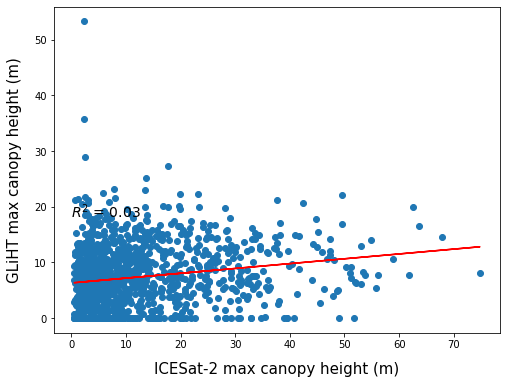

In [71]:
data = pd.read_csv("gliht_icesat2_compare", header=None, sep=" ", names=["gliht", "icesat2"])

## Remove outliers from data
#data = data[(data["icesat2"] < 30) & (data["gliht"] < 30)]

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(data["icesat2"],data["gliht"],"o")
ax.set_xlabel("ICESat-2 max canopy height (m)", fontsize=15, labelpad=12)
ax.set_ylabel("GLiHT max canopy height (m)", fontsize=15, labelpad=12)

# Linear regression
reg = LinearRegression().fit(np.array(data["icesat2"]).reshape(-1, 1), np.array(data["gliht"]).reshape(-1, 1))
m = reg.coef_[0][0]
c = reg.intercept_
ax.plot(data["icesat2"], m*data["icesat2"] + c, c='red')
r2 = str(round(reg.score(np.array(data["icesat2"]).reshape(-1, 1), np.array(data["gliht"]).reshape(-1, 1)), 2))
ax.text(0,18,"$R^2$ = %s" %r2, fontsize=14)

plt.show()